# Gemma 3N D-Fire Dataset Fine-tuning

Fine-tune Gemma 3N on the D-Fire dataset for fire and smoke detection. This notebook demonstrates how to:

1. Load and preprocess D-Fire dataset images with labels
2. Create vision-text pairs for fire/smoke detection
3. Fine-tune the multimodal model on the dataset
4. Configure the number of images used for training

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!

<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### D-Fire Dataset Fine-tuning Configuration

**Key Features:**
- 🔥 **Fire/Smoke Detection**: Fine-tune on D-Fire dataset for fire and smoke detection
- 🎯 **Configurable Dataset Size**: Set `MAX_IMAGES_PER_CATEGORY` to control training data size
- 🖼️ **Vision Fine-tuning**: Enabled vision layers for multimodal learning
- 📊 **Balanced Categories**: Automatically balances fire, smoke, both, and none categories
- 🔄 **Adaptive Training**: Training steps adjust automatically based on dataset size

**Configuration Parameters:**
- `DATASET_PATH`: Path to your D-Fire dataset
- `MAX_IMAGES_PER_CATEGORY`: Number of images per category (default: 200)
- `DETECTION_PROMPT`: The prompt used for fire/smoke detection

### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Verify the D-Fire dataset structure
import os
dataset_base_path = "/content/drive/MyDrive/D-Fire"

print("Checking D-Fire dataset structure...")
if os.path.exists(dataset_base_path):
    print(f"✅ Found D-Fire folder at: {dataset_base_path}")

    # Check for train and test folders
    train_path = os.path.join(dataset_base_path, "train")
    test_path = os.path.join(dataset_base_path, "test")

    if os.path.exists(train_path):
        print(f"✅ Found train folder: {train_path}")
        train_images = os.path.join(train_path, "images")
        train_labels = os.path.join(train_path, "labels")
        if os.path.exists(train_images) and os.path.exists(train_labels):
            print(f"✅ Found train/images and train/labels folders")
            print(f"   - Images: {len(os.listdir(train_images))} files")
            print(f"   - Labels: {len(os.listdir(train_labels))} files")
        else:
            print("⚠️ Missing train/images or train/labels folders")
    else:
        print("❌ Train folder not found")

    if os.path.exists(test_path):
        print(f"✅ Found test folder: {test_path}")
        test_images = os.path.join(test_path, "images")
        test_labels = os.path.join(test_path, "labels")
        if os.path.exists(test_images) and os.path.exists(test_labels):
            print(f"✅ Found test/images and test/labels folders")
            print(f"   - Images: {len(os.listdir(test_images))} files")
            print(f"   - Labels: {len(os.listdir(test_labels))} files")
        else:
            print("⚠️ Missing test/images or test/labels folders")
    else:
        print("❌ Test folder not found")

else:
    print(f"❌ D-Fire dataset not found at: {dataset_base_path}")
    print("Please ensure your D-Fire dataset is uploaded to Google Drive at /MyDrive/D-Fire/")
    print("Expected structure:")
    print("/content/drive/MyDrive/D-Fire/")
    print("├── train/")
    print("│   ├── images/")
    print("│   └── labels/")
    print("└── test/")
    print("    ├── images/")
    print("    └── labels/")


Mounted at /content/drive
Checking D-Fire dataset structure...
✅ Found D-Fire folder at: /content/drive/MyDrive/D-Fire
✅ Found train folder: /content/drive/MyDrive/D-Fire/train
✅ Found train/images and train/labels folders
   - Images: 17231 files
   - Labels: 17221 files
✅ Found test folder: /content/drive/MyDrive/D-Fire/test
✅ Found test/images and test/labels folders
   - Images: 4306 files
   - Labels: 4306 files


In [3]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps transformers==4.53.1 # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [4]:
!pip show transformers

Name: transformers
Version: 4.53.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers, trl, unsloth, unsloth_zoo


### Unsloth

`FastModel` supports loading nearly any model now! This includes Vision and Text models!

In [5]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
    # Pretrained models
    "unsloth/gemma-3n-E4B-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-unsloth-bnb-4bit",

    # Other Gemma 3 quants
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E4B-it",
    dtype = None, # None for auto detection
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Gemma3N patching. Transformers: 4.53.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

# Gemma 3N can process Text, Vision and Audio!

Let's first experience how Gemma 3N can handle multimodal inputs. We use Gemma 3N's recommended settings of `temperature = 1.0, top_p = 0.95, top_k = 64`

In [ ]:
from transformers import TextStreamer
# Helper function for inference
def do_gemma_3n_inference(messages, max_new_tokens = 128):
    _ = model.generate(
        **tokenizer.apply_chat_template(
            messages,
            add_generation_prompt = True, # Must add for generation
            tokenize = True,
            return_dict = True,
            return_tensors = "pt",
        ).to("cuda"),
        max_new_tokens = max_new_tokens,
        temperature = 1.0, top_p = 0.95, top_k = 64,
        streamer = TextStreamer(tokenizer, skip_prompt = True),
    )

# Gemma 3N can see images!

<img src="https://files.worldwildlife.org/wwfcmsprod/images/Sloth_Sitting_iStock_3_12_2014/story_full_width/8l7pbjmj29_iStock_000011145477Large_mini__1_.jpg" alt="Alt text" height="256">

In [ ]:
sloth_link = "https://files.worldwildlife.org/wwfcmsprod/images/Sloth_Sitting_iStock_3_12_2014/story_full_width/8l7pbjmj29_iStock_000011145477Large_mini__1_.jpg"

messages = [{
    "role" : "user",
    "content": [
        { "type": "image", "image" : sloth_link },
        { "type": "text",  "text" : "Which films does this animal feature in?" }
    ]
}]
# You might have to wait 1 minute for Unsloth's auto compiler
do_gemma_3n_inference(messages, max_new_tokens = 256)

Let's make a poem about sloths!

In [ ]:
messages = [{
    "role": "user",
    "content": [{ "type" : "text",
                  "text" : "Write a poem about sloths." }]
}]
do_gemma_3n_inference(messages)

# Gemma 3N can also hear!

In [ ]:
from IPython.display import Audio, display
Audio("https://www.nasa.gov/wp-content/uploads/2015/01/591240main_JFKmoonspeech.mp3")

In [ ]:
!wget -qqq https://www.nasa.gov/wp-content/uploads/2015/01/591240main_JFKmoonspeech.mp3 -O audio.mp3

In [ ]:
audio_file = "audio.mp3"

messages = [{
    "role" : "user",
    "content": [
        { "type": "audio", "audio" : audio_file },
        { "type": "text",  "text" : "What is this audio about?" }
    ]
}]
do_gemma_3n_inference(messages, max_new_tokens = 256)

# Let's combine all 3 modalities together!

In [ ]:
messages = [{
    "role" : "user",
    "content": [
        { "type": "audio", "audio" : audio_file },
        { "type": "image", "image" : sloth_link },
        { "type": "text",  "text" : "What is this audio and image about? "\
                                    "How are they related?" }
    ]
}]
do_gemma_3n_inference(messages, max_new_tokens = 256)

# Let's finetune Gemma 3N!

You can finetune the vision and text parts for now through selection - the audio part can also be finetuned - we're working to make it selectable as well!

We now add LoRA adapters so we only need to update a small amount of parameters!

In [6]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = True,  # Turn ON for vision tasks!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # Should leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We now use the `Gemma-3` format for conversation style finetunes with the D-Fire dataset. We'll create vision-text pairs for fire/smoke detection. Each sample will contain an image and the corresponding question/answer about fire or smoke presence.

Gemma-3 renders multi turn conversations like below:
```
<bos><start_of_turn>user
<image>
Is there fire or smoke visible in this image?<end_of_turn>
<start_of_turn>model  
fire<end_of_turn>
```

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3, phi4, qwen2.5, gemma3` and more.

In [7]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

### D-Fire Dataset Configuration

Configure the number of images to use for training per category:

In [8]:
# Configuration for D-Fire dataset
DATASET_PATH = "/content/drive/MyDrive/D-Fire"  # Update this path to your D-Fire dataset location
MAX_IMAGES_PER_CATEGORY = 200  # Number of images to use per category (fire, smoke, both, none)
TOTAL_IMAGES = MAX_IMAGES_PER_CATEGORY * 4  # Total images for training

# Define the detection prompt and category mappings
DETECTION_PROMPT = "Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'."
CATEGORY_LABELS = {
    "fire": "fire",
    "smoke": "smoke",
    "both": "both",
    "none": "none"
}

print(f"Configured to use {MAX_IMAGES_PER_CATEGORY} images per category")
print(f"Total training images: {TOTAL_IMAGES}")
print(f"Detection prompt: {DETECTION_PROMPT}")

Configured to use 200 images per category
Total training images: 800
Detection prompt: Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.


Load the D-Fire dataset with the custom dataset loader:

In [9]:
import os
import random
from pathlib import Path
from datasets import Dataset
from PIL import Image
import pandas as pd

class DFireDatasetLoader:
    """Custom D-Fire dataset loader for fire and smoke detection."""

    def __init__(self, dataset_path: str):
        self.dataset_path = Path(dataset_path)
        self.train_path = self.dataset_path / "train"
        self.test_path = self.dataset_path / "test"

    def _load_yolo_labels(self, labels_dir: Path) -> dict:
        """Load YOLO format labels from directory."""
        labels = {}
        for label_file in labels_dir.glob("*.txt"):
            image_name = label_file.stem
            annotations = []

            if label_file.stat().st_size > 0:
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            annotations.append({
                                'class_id': class_id,
                                'class_name': 'smoke' if class_id == 0 else 'fire'
                            })
            labels[image_name] = annotations
        return labels

    def _categorize_images(self, labels: dict) -> dict:
        """Categorize images based on their annotations."""
        categories = {'fire': [], 'smoke': [], 'both': [], 'none': []}

        for image_name, annotations in labels.items():
            if not annotations:
                categories['none'].append(image_name)
            else:
                has_fire = any(ann['class_name'] == 'fire' for ann in annotations)
                has_smoke = any(ann['class_name'] == 'smoke' for ann in annotations)

                if has_fire and has_smoke:
                    categories['both'].append(image_name)
                elif has_fire:
                    categories['fire'].append(image_name)
                elif has_smoke:
                    categories['smoke'].append(image_name)
                else:
                    categories['none'].append(image_name)

        return categories

    def load_dataset(self, split: str = "train", max_per_category: int = 200, seed: int = 42) -> list:
        """Load dataset with specified number of images per category."""
        random.seed(seed)

        split_path = self.train_path if split == "train" else self.test_path
        images_dir = split_path / "images"
        labels_dir = split_path / "labels"

        # Load labels and categorize
        labels = self._load_yolo_labels(labels_dir)
        categories = self._categorize_images(labels)

        # Get available images
        available_images = set(img.stem for img in images_dir.glob("*.[jp][pn]g"))

        # Filter and sample
        sample_data = []
        for category, image_names in categories.items():
            available_names = [name for name in image_names if name in available_images]
            if available_names:
                sampled = random.sample(available_names, min(max_per_category, len(available_names)))
                for image_name in sampled:
                    image_path = images_dir / f"{image_name}.jpg"
                    if not image_path.exists():
                        image_path = images_dir / f"{image_name}.png"

                    if image_path.exists():
                        sample_data.append({
                            'image_path': str(image_path),
                            'category': category,
                            'label': CATEGORY_LABELS[category],
                            'image_name': image_name
                        })

        return sample_data

# Load the D-Fire dataset
if os.path.exists(DATASET_PATH):
    loader = DFireDatasetLoader(DATASET_PATH)
    dataset_samples = loader.load_dataset(split="train", max_per_category=MAX_IMAGES_PER_CATEGORY)
    print(f"Loaded {len(dataset_samples)} samples from D-Fire dataset")

    # Show distribution
    from collections import Counter
    category_counts = Counter([sample['category'] for sample in dataset_samples])
    print(f"Category distribution: {dict(category_counts)}")
else:
    print(f"Dataset path not found: {DATASET_PATH}")
    print("Please update DATASET_PATH to point to your D-Fire dataset location")
    dataset_samples = []

Loaded 800 samples from D-Fire dataset
Category distribution: {'fire': 200, 'smoke': 200, 'both': 200, 'none': 200}


Let's see how a sample from our D-Fire dataset looks like!

Sample from D-Fire dataset:
Image path: /content/drive/MyDrive/D-Fire/train/images/AoF04542.jpg
Category: fire
Label: fire
Image name: AoF04542


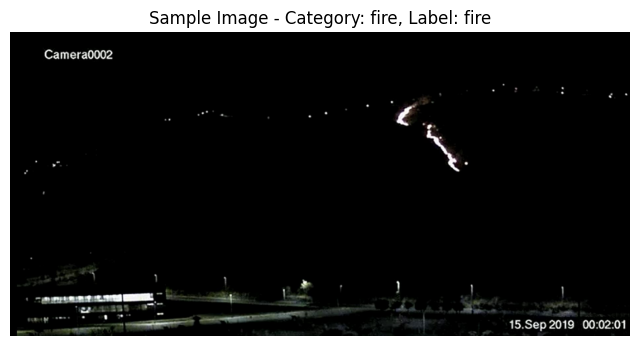

In [10]:
if dataset_samples:
    print("Sample from D-Fire dataset:")
    sample = dataset_samples[0]
    print(f"Image path: {sample['image_path']}")
    print(f"Category: {sample['category']}")
    print(f"Label: {sample['label']}")
    print(f"Image name: {sample['image_name']}")

    # Display the image
    from PIL import Image
    import matplotlib.pyplot as plt

    img = Image.open(sample['image_path'])
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Sample Image - Category: {sample['category']}, Label: {sample['label']}")
    plt.axis('off')
    plt.show()
else:
    print("No dataset samples loaded. Please check the DATASET_PATH.")

Now we'll convert our D-Fire dataset samples into the conversation format for `Gemma-3`. Each sample will be formatted as a multimodal conversation with an image and question/answer about fire or smoke detection. We remove the `<bos>` token using removeprefix(`'<bos>'`) since we're finetuning.

In [12]:
def format_dfire_conversations(dataset_samples):
    """Convert D-Fire samples to conversation format."""
    conversations = []

    for sample in dataset_samples:
        # Create conversation for each sample
        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": sample['image_path']},
                    {"type": "text", "text": DETECTION_PROMPT}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": sample['label']}
                ]
            }
        ]
        conversations.append(conversation)

    return conversations

def formatting_prompts_func(examples):
    """Format conversations for training."""
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False).removeprefix('<bos>') for convo in convos]
    return {"text": texts}

if dataset_samples:
    # Convert to conversation format
    conversations = format_dfire_conversations(dataset_samples)

    # Create dataset
    dataset = Dataset.from_dict({"conversations": conversations})

    # Apply Unsloth's standardization (ensures VLM format compliance)
    # from unsloth.chat_templates import standardize_data_formats
    # dataset = standardize_data_formats(dataset, tokenizer)

    # Apply chat template
    dataset = dataset.map(formatting_prompts_func, batched=True)

    print(f"Created dataset with {len(dataset)} samples")
    print(f"Dataset columns: {dataset.column_names}")
else:
    print("No dataset samples to format. Please check the DATASET_PATH.")

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Created dataset with 800 samples
Dataset columns: ['conversations', 'text']


Let's see how the chat template formatted our D-Fire conversation! Notice there is no `<bos>` token as the processor tokenizer will be adding one.

In [13]:
if dataset_samples and len(dataset) > 0:
    print("Formatted conversation example:")
    print(dataset[0]["text"])
else:
    print("No formatted dataset available.")

Formatted conversation example:
<start_of_turn>user
<start_of_image>Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.<end_of_turn>
<start_of_turn>model
fire<end_of_turn>



<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [20]:
from trl import SFTTrainer, SFTConfig

# Configure training parameters based on dataset size
if dataset_samples:
    dataset_size = len(dataset_samples)
    # Adjust training steps based on dataset size
    if dataset_size < 100:
        max_steps = 30
    elif dataset_size < 500:
        max_steps = 60
    else:
        max_steps = 100

    print(f"Dataset size: {dataset_size}")
    print(f"Training steps: {max_steps}")

    trainer = SFTTrainer(
        model = model,
        tokenizer = tokenizer,
        train_dataset = dataset,
        eval_dataset = None, # Can set up evaluation!
        args = SFTConfig(
            dataset_text_field = "text",
            per_device_train_batch_size = 1,
            gradient_accumulation_steps = 4, # Use GA to mimic batch size!
            warmup_steps = 5,
            # num_train_epochs = 1, # Set this for 1 full training run.
            max_steps = max_steps,
            learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
            logging_steps = 1,
            optim = "adamw_8bit",
            weight_decay = 0.01,
            lr_scheduler_type = "linear",
            seed = 3407,
            report_to = "none", # Use this for WandB etc
        ),
    )
else:
    print("No dataset loaded. Cannot create trainer.")

Dataset size: 800
Training steps: 100


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs. This helps increase accuracy of finetunes!

In [15]:
if dataset_samples and 'trainer' in locals():
    from unsloth.chat_templates import train_on_responses_only
    trainer = train_on_responses_only(
        trainer,
        instruction_part = "<start_of_turn>user\n",
        response_part = "<start_of_turn>model\n",
    )
    print("Trainer configured to train only on model responses.")
else:
    print("Trainer not available for response masking configuration.")

Map (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

Trainer configured to train only on model responses.


Let's verify masking the instruction part is done! Let's print the 100th row again.  Notice how the sample only has a single `<bos>` as expected!

In [16]:
if dataset_samples and 'trainer' in locals() and len(trainer.train_dataset) > 0:
    print("Training dataset sample (input_ids):")
    print(tokenizer.decode(trainer.train_dataset[0]["input_ids"]))
else:
    print("Training dataset not available for inspection.")

Training dataset sample (input_ids):
<bos><start_of_turn>user
<start_of_image>Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'.<end_of_turn>
<start_of_turn>model
fire<end_of_turn>



Now let's print the masked out example - you should see only the answer is present:

In [17]:
if dataset_samples and 'trainer' in locals() and len(trainer.train_dataset) > 0:
    print("Training dataset sample (labels - masked):")
    print(tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " "))
else:
    print("Training dataset not available for label inspection.")

Training dataset sample (labels - masked):
                                    fire<end_of_turn>



In [18]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
12.592 GB of memory reserved.


# Let's train the model!

To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [19]:
if dataset_samples and 'trainer' in locals():
    trainer_stats = trainer.train()
    print("Training completed successfully!")
else:
    print("Cannot start training: No dataset loaded or trainer not initialized.")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 19,210,240 of 4,000,000,000 (0.48% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,14.784200
2,15.643300
3,14.257600
4,15.148200
5,15.595800
6,16.090800
7,15.200200
8,15.595800
9,15.496300
10,16.486400


Training completed successfully!


In [21]:
# @title Show final memory and time stats
if 'trainer_stats' in locals():
    used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
    used_percentage = round(used_memory / max_memory * 100, 3)
    lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
    print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
    print(
        f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
    )
    print(f"Peak reserved memory = {used_memory} GB.")
    print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
    print(f"Peak reserved memory % of max memory = {used_percentage} %.")
    print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")
else:
    print("Training was not executed, so no stats to display.")

732.1333 seconds used for training.
12.2 minutes used for training.
Peak reserved memory = 12.592 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 85.422 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Gemma-3` team, the recommended settings for inference are `temperature = 1.0, top_p = 0.95, top_k = 64`

In [ ]:
DETECTION_PROMPT = "Is there fire or smoke visible in this image? Answer with: 'fire', 'smoke', 'both', or 'none'."

from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

# Test the model on fire/smoke detection
if dataset_samples:
    # Use a sample from our dataset for testing
    test_sample = dataset_samples[0]
    test_image_path = test_sample['image_path']

    print(test_image_path)

    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": test_image_path},
            {"type": "text", "text": DETECTION_PROMPT}
        ]
    }]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt = True, # Must add for generation
        return_tensors = "pt",
        tokenize = True,
        return_dict = True,
    ).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens = 16, # Short response expected
        # Recommended Gemma-3 settings!
        temperature = 1.0, top_p = 0.95, top_k = 64,
    )

    print(f"Testing on image: {test_sample['image_name']}")
    print(f"Ground truth: {test_sample['label']}")
    print(f"Model response: {tokenizer.batch_decode(outputs)[0]}")
else:
    print("No dataset samples available for testing.")

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# Test with multiple samples from different categories
if dataset_samples and len(dataset_samples) > 5:
    from transformers import TextStreamer

    # Test with samples from different categories
    test_samples = dataset_samples[:5]  # Test with first 5 samples

    for i, sample in enumerate(test_samples):
        print(f"\n--- Test {i+1} ---")
        print(f"Category: {sample['category']}, Expected: {sample['label']}")

        messages = [{
            "role": "user",
            "content": [
                {"type": "image", "image": sample['image_path']},
                {"type": "text", "text": DETECTION_PROMPT}
            ]
        }]

        inputs = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt = True,
            return_tensors = "pt",
            tokenize = True,
            return_dict = True,
        ).to("cuda")

        print("Model response: ", end="")
        _ = model.generate(
            **inputs,
            max_new_tokens = 16,
            temperature = 1.0, top_p = 0.95, top_k = 64,
            streamer = TextStreamer(tokenizer, skip_prompt = True),
        )
else:
    print("Not enough dataset samples for comprehensive testing.")

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [26]:
model.save_pretrained("gemma-3n")  # Local saving
tokenizer.save_pretrained("gemma-3n")
# model.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving
# tokenizer.push_to_hub("HF_ACCOUNT/gemma-3", token = "...") # Online saving

['gemma-3n/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastModel
    model, tokenizer = FastModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

messages = [{
    "role": "user",
    "content": [{"type" : "text", "text" : "What is Gemma-3N?",}]
}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
    tokenize = True,
    return_dict = True,
).to("cuda")

from transformers import TextStreamer
_ = model.generate(
    **inputs,
    max_new_tokens = 128, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

### Saving to float16 for VLLM

We also support saving to `float16` directly for deployment! We save it in the folder `gemma-3N-finetune`. Set `if False` to `if True` to let it run!

In [ ]:
if True: # Change to True to save finetune!
    model.save_pretrained_merged("gemma-3N-finetune", tokenizer)

If you want to upload / push to your Hugging Face account, set `if False` to `if True` and add your Hugging Face token and upload location!

In [ ]:
if False: # Change to True to upload finetune
    model.push_to_hub_merged(
        "HF_ACCOUNT/gemma-3N-finetune", tokenizer,
        token = "hf_..."
    )

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now for all models! For now, you can convert easily to `Q8_0, F16 or BF16` precision. `Q4_K_M` for 4bit will come later!

In [ ]:
if True: # Change to True to save to GGUF
    model.save_pretrained_gguf(
        "gemma-3N-finetune",
        quantization_type = "Q8_0", # For now only Q8_0, BF16, F16 supported
    )

Likewise, if you want to instead push to GGUF to your Hugging Face account, set `if False` to `if True` and add your Hugging Face token and upload location!

In [ ]:
if False: # Change to True to upload GGUF
    model.push_to_hub_gguf(
        "gemma-3N-finetune",
        quantization_type = "Q8_0", # Only Q8_0, BF16, F16 supported
        repo_id = "HF_ACCOUNT/gemma-3N-finetune-gguf",
        token = "hf_...",
    )

## D-Fire Fine-tuning Summary

### What This Notebook Does:
1. **Loads D-Fire Dataset**: Custom dataset loader for fire/smoke detection images
2. **Creates Vision-Text Pairs**: Converts images to multimodal conversation format
3. **Fine-tunes Gemma 3N**: Enables vision layers and trains on fire/smoke detection
4. **Tests Performance**: Evaluates model on detection tasks

### Configuration:
- **Dataset Path**: Update `DATASET_PATH` to point to your D-Fire dataset
- **Training Size**: Adjust `MAX_IMAGES_PER_CATEGORY` (default: 200 per category)
- **Categories**: Automatically handles fire, smoke, both, and none classifications

### Usage:
1. Set your D-Fire dataset path in the configuration cell
2. Adjust `MAX_IMAGES_PER_CATEGORY` based on your needs and computational resources
3. Run all cells to train the model
4. Use the trained model for fire/smoke detection in images

### Model Output:
The fine-tuned model will respond with one of four labels:
- `fire`: Only fire detected
- `smoke`: Only smoke detected  
- `both`: Both fire and smoke detected
- `none`: No fire or smoke detected

### Next Steps:
- Use the `gemma-3N-finetune.gguf` file in llama.cpp or UI systems like Jan/Open WebUI
- Deploy the model for real-time fire/smoke detection applications
- Evaluate performance on your specific use case

---

**Original Unsloth Resources:**

Now, use the `gemma-3N-finetune.gguf` file or `gemma-3N-finetune-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
